In [1]:
# import the libraries we need, setup inline plotting

import pylab as pl
import pykat
% matplotlib inline
import matplotlib

                                              ..-
    PyKat 0.8.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



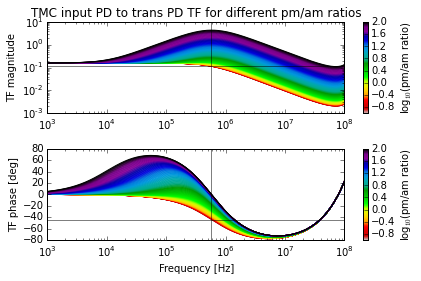

In [65]:
# Define some constants. Cavity pole frequency comes from trace 2 output of kat file.

cavpole=573.22517*1e3
pi=pl.pi


basekatfile = 'Tcav_RFjitter.kat'

# Creat kat object and read in the kat file with the optical layout
basekat = pykat.finesse.kat()
basekat.verbose = False
basekat.loadKatFile(basekatfile)

# Copy kat object to one that we can manipulate
kat = basekat.deepcopy()

# Add in RF detectors in the cavity input beam and the cavity transmission port
kat.parseCommands("""
        pd1 pdtrans 1 nMCTRANS
        pd1 pdin 1 nMC1in*
        """)

# Sweep EOM and EOAM frequency, make sure RF PD demod frequency is swept along
kat.parseCommands("""
        xaxis sweptEOM f log 1k 100M 1000
        put sweptEOAM f $x1
        put pdtrans f1 $x1
        put pdin f1 $x1
        yaxis log abs:deg
        """)

# Add a small offset to the cavity tuning
kat.MC2.phi = 0.1

# Make a vector of modulation indices for the amplitude modulation source
am_amps = pl.logspace(0,-3,150)

# Set up a colormap so that we can plot different lines for different am midxs in different
# colors along a scalar mappable color axis
cm = pl.cm.spectral_r
norm = matplotlib.colors.Normalize(vmin=pl.log10(min(kat.sweptEOM.midx.value/am_amps)), vmax=pl.log10(max(kat.sweptEOM.midx.value/am_amps)))
s_m = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
s_m.set_array([])

# start a figure with two subplots, add labels etc.
fig=pl.figure()
ax1=fig.add_subplot(2,1,1)
pl.ylabel('TF magnitude')
pl.title('TMC input PD to trans PD TF for different pm/am ratios')
cb = pl.colorbar(s_m)
cb.set_label("log$_{10}$(pm/am ratio)")
ax2=fig.add_subplot(2,1,2)
pl.ylabel('TF phase')
cb = pl.colorbar(s_m)
cb.set_label("log$_{10}$(pm/am ratio)")

# Now looping over am midxs, plot the measured cavity TF in a line with color determined by the pm/am ratio
for i, amp in enumerate(am_amps):
    tkat = kat.deepcopy()
    tkat.sweptEOAM.midx = amp
    out = tkat.run()
    TF = out["pdtrans"]/out["pdin"]
    TFmag = abs(TF)
    TFphase = pl.angle(TF)*180/pi
    am2pm = tkat.sweptEOAM.midx.value/tkat.sweptEOM.midx.value
    c = s_m.to_rgba(-pl.log10(am2pm))
    ax1.loglog(out.x,TFmag,label=labelstr,color=c,linewidth=1)
    ax2.semilogx(out.x,TFphase,color=c,linewidth=1)
# Add horizontal lines at the 1/√2 from DC level for the magnitude plot, and -45deg for the phase plot
ax1.axhline(y=TFmag[0]/pl.sqrt(2),linewidth=0.5,color='black')
ax2.axhline(y=-45,linewidth=0.5,color='black')
# Add vertical lines at the trace 2 output cavity pole frequency
ax1.axvline(x=cavpole,linewidth=0.5,color='black')
ax2.axvline(x=cavpole,linewidth=0.5,color='black')
pl.ylabel('TF phase [deg]')
pl.xlabel('Frequency [Hz]')
fig.tight_layout()

# Save the figure
fig.savefig('plots/cavpole_w_am2pm_ratios_spectral_r.pdf')